<a href="https://colab.research.google.com/github/MuralidharB/tft-stocks/blob/master/correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Installation
!pip install --upgrade mxnet==1.6.0
!pip install gluonts
!pip install yfinance
!pip install datasets
!pip install transformers
!pip install accelerate
!pip install torch
!pip install evaluate
!pip install torchviz
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


                           ETH-USD_Volume  ETH-USD_Open  BTC-USD_Volume  \
Date                                                                      
2018-03-18 00:00:00+00:00       -1.005360     -0.516436       -1.051513   
2018-03-19 00:00:00+00:00       -1.065279     -0.520607       -1.046925   
2018-03-20 00:00:00+00:00       -1.085271     -0.512210       -1.065669   
2018-03-21 00:00:00+00:00       -1.090188     -0.510232       -1.081930   
2018-03-22 00:00:00+00:00       -1.114374     -0.507734       -1.108096   
...                                   ...           ...             ...   
2023-03-13 00:00:00+00:00        0.216634      0.347879        1.133963   
2023-03-14 00:00:00+00:00        0.258691      0.422289        1.397067   
2023-03-15 00:00:00+00:00       -0.064439      0.442994        0.837444   
2023-03-16 00:00:00+00:00       -0.378744      0.402358        0.337877   
2023-03-18 00:00:00+00:00       -0.037167      0.516530        1.200435   

                        

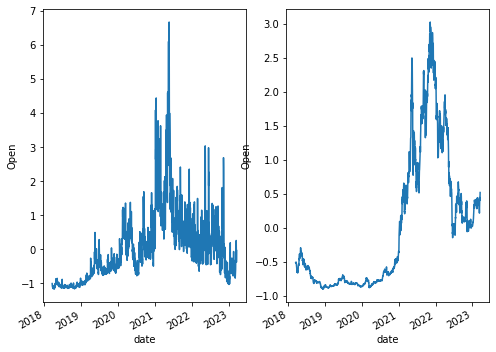

In [31]:
import yfinance as yahooFinance
import tensorflow as tf
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

stocks = ['BTC-USD', 'ETH-USD']

stocks_ts = pd.DataFrame()
for stock in stocks:
    data = yahooFinance.Ticker(stock).history(period="5y")
    d = data.copy()[['Open', 'Volume']]
    d=(d-d.mean())/d.std()
    stocks_ts.insert(0, stock+"_Open", d['Open'])
    stocks_ts.insert(0, stock+"_Volume", d['Volume'])

print(stocks_ts)


# add other indicators
# inflation rate, interest rate, employment

fig, axs = plt.subplots(1, 2, figsize=(8, 6), sharex=True)
axx = axs.ravel()
for i in range(0, 2):
    stocks_ts[stocks_ts.columns[i]].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("Open")   
    axx[i].grid(which='minor', axis='x')

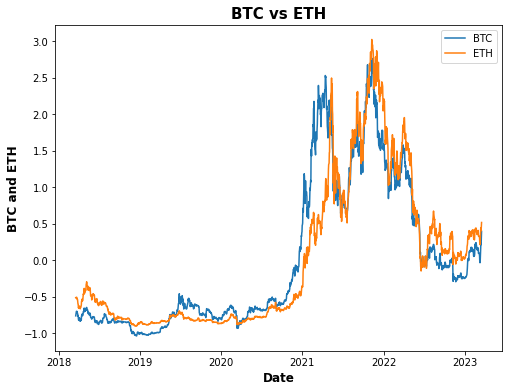

In [33]:
import seaborn as sns
fig = plt.figure(figsize = (8, 6))
sns.lineplot(data = stocks_ts, x = 'Date', y ='BTC-USD_Open', label='BTC')
sns.lineplot(data = stocks_ts, x = 'Date', y ='ETH-USD_Open', label='ETH')
plt.title('BTC vs ETH', weight='bold', fontsize = 15)
plt.ylabel('BTC and ETH', weight='bold', fontsize = 12)
plt.xlabel('Date', weight='bold', fontsize = 12)
plt.legend()
plt.show()

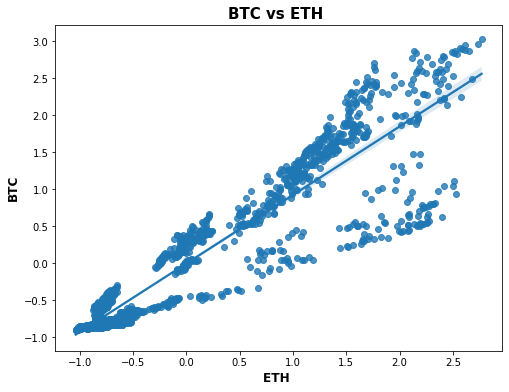

In [38]:
fig = plt.figure(figsize = (8, 6))
sns.regplot(data = stocks_ts, x = 'BTC-USD_Open', y = 'ETH-USD_Open')
plt.title('BTC vs ETH ', weight='bold', fontsize = 15)
plt.ylabel('BTC', weight='bold', fontsize = 12)
plt.xlabel('ETH ', weight='bold', fontsize = 12)
plt.show()

In [40]:
from scipy import signal
import numpy as np
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c
    
ccf_ielts = ccf_values(stocks_ts['BTC-USD_Open'], stocks_ts['ETH-USD_Open'])
ccf_ielts

array([-0.00021621, -0.00037703, -0.00055192, ..., -0.00023801,
       -0.00017259, -0.0001116 ])

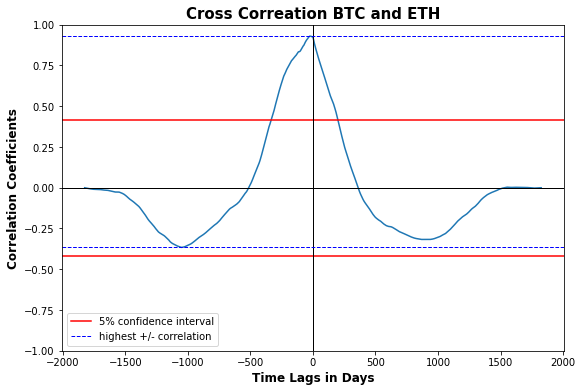

In [42]:
from scipy import signal

lags = signal.correlation_lags(len(stocks_ts['BTC-USD_Open']), len(stocks_ts['ETH-USD_Open']))

def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correation BTC and ETH', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags in Days', weight='bold', fontsize = 12)
    plt.legend()
    
ccf_plot(lags, ccf_ielts)